In [1]:
# math operations
import numpy as np
import tensorflow as tf
# machine learning
import cv2
import matplotlib.pyplot as plt
# Doing One hot encoding as classifier has multiple classes
from random import shuffle
import keras
# MobileNetV2 model
from keras.models import load_model
import matplotlib as mpl

import tensorflow as tf
import cv2
from skimage import img_as_ubyte
from skimage.transform import resize

2024-06-07 21:18:53.892646: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-07 21:18:53.912736: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 21:18:54.221948: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
model = load_model('/home/abidhasan/Documents/Indicate_FH/saved_model/mobilenetv2_100.h5')

2024-06-07 21:18:56.313327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-07 21:18:56.325610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-07 21:18:56.325718: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [4]:
# Function to preprocess images
affected_img1 = "/home/abidhasan/Documents/Indicate_FH/train_val_test/test/effected/001_CLE204_Baseline_111.png"
affected_img2 = "/home/abidhasan/Documents/Indicate_FH/data/effected/001_CLE114_Baseline_112.png"
affected_img3 = "/home/abidhasan/Documents/Indicate_FH/data/effected/007_CLE203_Weizen_114.png"
affected_img4 = "/home/abidhasan/Documents/Indicate_FH/data/effected/CLE101_Baseline_Reaktion_CLE101_Baseline_Reaktion_3.png"
non_affected_img = "/home/abidhasan/Documents/Indicate_FH/train_val_test/test/not_effected/001_CLE197_Baseline_4.png"

In [5]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(
            last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [6]:
# Remove last layer's softmax
model.layers[-1].activation = None

In [8]:
img_array = get_img_array(affected_img1, size=(224,224))

2024-06-07 21:19:59.395785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-06-07 21:19:59.427848: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-06-07 21:19:59.427866: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-06-07 21:19:59.427945: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-06-07 21:19:59.463986: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


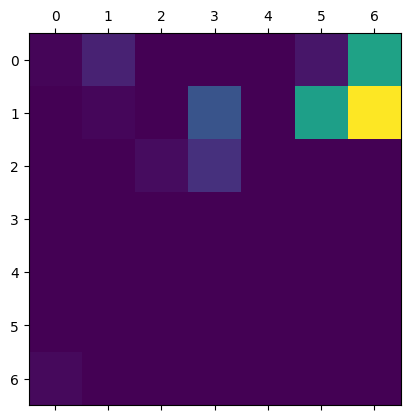

In [9]:
# Generate class activation heatmap
last_conv_layer_name = "block_16_depthwise"
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [10]:
print("shape of HEATMAP image: ", heatmap.shape)
print("Max Pixel value:", np.max(heatmap))
print("Min pixel value", np.min(heatmap))

shape of HEATMAP image:  (7, 7)
Max Pixel value: 1.0
Min pixel value 0.0


Image shape (512, 512, 3)
Image Max Pixel value: 255.0
Shape of Jet_heatmap: (512, 512, 3)
Jet Heatmap Max Pixel value: 255.0


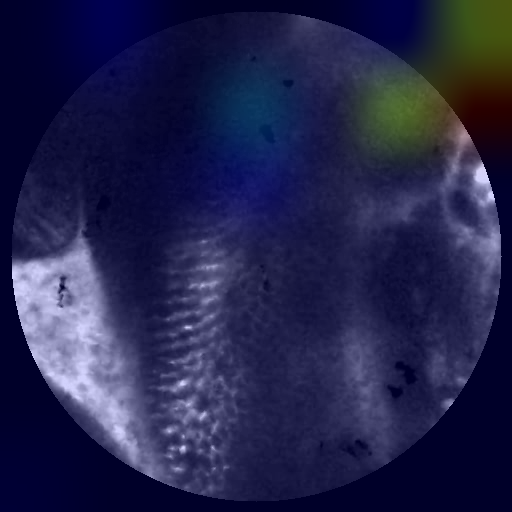

In [13]:
from IPython.display import Image, display


def save_and_display_gradcam(img_path, heatmap, cam_path="/home/abidhasan/Documents/Indicate_FH/grad_cam_images/image1.png", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)
    print("Image shape {}".format(img.shape))
    print("Image Max Pixel value: {}".format(np.max(img)))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)
    
    print('Shape of Jet_heatmap: {}'.format(jet_heatmap.shape))
    print("Jet Heatmap Max Pixel value: {}".format(np.max(jet_heatmap)))

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(affected_img1, heatmap)

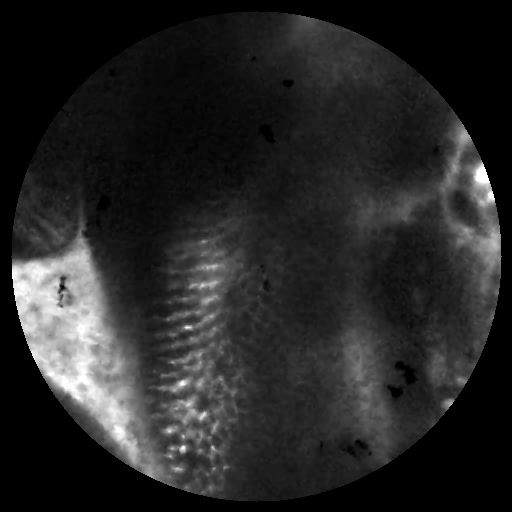

: 

In [15]:
display(Image(affected_img1))
